In [50]:
import os
import io
import sys
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
import PIL

prj_dir = os.path.abspath(os.getcwd() + '/..')
print(prj_dir)
sys.path.append(prj_dir)

/Users/omarolivares/Documents/DataMexico/rulo_mota_omath


In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import shap
from sklearn.model_selection import train_test_split

from src import config
from src.features import X_features
from src.features import banxico_mun_income_remittances

In [3]:
path = os.path.join(
    config.PRJ_DIR,
    'data/processed/X.csv')

data = pd.read_csv(path)
data.set_index('id', inplace=True)

remittances = banxico_mun_income_remittances.get()

In [4]:
X_2019 = data[data['year'] == 2019].drop(
    ['year', 'mun', 'year.1','year.2', 'mun.1', 'mun.2'], 
    axis=1).apply(lambda x: np.log1p(x))

valid_ids_2019 = list(set(remittances.index).intersection(X_2019.index))

X_2019 = X_2019.loc[valid_ids_2019]
y_2019 = remittances.loc[valid_ids_2019]['Remittance Amount Million USD log1p']

divide by zero encountered in log1p
invalid value encountered in log1p


In [5]:
X_2020 = data[data['year'] == 2020].drop(
    ['year', 'mun', 'year.1','year.2', 'mun.1', 'mun.2'], 
    axis=1).apply(lambda x: np.log1p(x))

valid_ids_2020 = list(set(remittances.index).intersection(X_2020.index))

X_2020 = X_2020.loc[valid_ids_2020]
y_2020 = remittances.loc[valid_ids_2020]['Remittance Amount Million USD log1p']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X_2019, y_2019, 
    train_size=.8,
    random_state=1)

eval_set = [
    (X_2020, y_2020),
    (X_train, y_train),
    (X_test, y_test)]

model = XGBRegressor(
    learning_rate=0.01, 
    max_depth=8, 
    n_estimators=1000,
    random_state=1)

model.fit(
    X_train, y_train,
    eval_set=eval_set,
    early_stopping_rounds=10,
    verbose=True)

[0]	validation_0-rmse:2.28864	validation_1-rmse:2.19701	validation_2-rmse:2.19739
[1]	validation_0-rmse:2.26945	validation_1-rmse:2.17698	validation_2-rmse:2.17882
[2]	validation_0-rmse:2.25013	validation_1-rmse:2.15717	validation_2-rmse:2.16029
[3]	validation_0-rmse:2.23136	validation_1-rmse:2.13758	validation_2-rmse:2.14217
[4]	validation_0-rmse:2.21282	validation_1-rmse:2.11817	validation_2-rmse:2.12407
[5]	validation_0-rmse:2.19425	validation_1-rmse:2.09898	validation_2-rmse:2.10636
[6]	validation_0-rmse:2.17614	validation_1-rmse:2.07999	validation_2-rmse:2.08865
[7]	validation_0-rmse:2.15772	validation_1-rmse:2.06116	validation_2-rmse:2.07127
[8]	validation_0-rmse:2.13973	validation_1-rmse:2.04252	validation_2-rmse:2.05405
[9]	validation_0-rmse:2.12172	validation_1-rmse:2.02407	validation_2-rmse:2.03699
[10]	validation_0-rmse:2.10436	validation_1-rmse:2.00585	validation_2-rmse:2.02017
[11]	validation_0-rmse:2.08682	validation_1-rmse:1.98777	validation_2-rmse:2.00350
[12]	validatio

[99]	validation_0-rmse:1.16831	validation_1-rmse:0.91959	validation_2-rmse:1.11732
[100]	validation_0-rmse:1.16264	validation_1-rmse:0.91185	validation_2-rmse:1.11229
[101]	validation_0-rmse:1.15701	validation_1-rmse:0.90420	validation_2-rmse:1.10705
[102]	validation_0-rmse:1.15152	validation_1-rmse:0.89663	validation_2-rmse:1.10184
[103]	validation_0-rmse:1.14607	validation_1-rmse:0.88915	validation_2-rmse:1.09672
[104]	validation_0-rmse:1.14072	validation_1-rmse:0.88175	validation_2-rmse:1.09178
[105]	validation_0-rmse:1.13525	validation_1-rmse:0.87443	validation_2-rmse:1.08684
[106]	validation_0-rmse:1.12943	validation_1-rmse:0.86720	validation_2-rmse:1.08203
[107]	validation_0-rmse:1.12418	validation_1-rmse:0.86001	validation_2-rmse:1.07739
[108]	validation_0-rmse:1.11863	validation_1-rmse:0.85295	validation_2-rmse:1.07279
[109]	validation_0-rmse:1.11395	validation_1-rmse:0.84584	validation_2-rmse:1.06820
[110]	validation_0-rmse:1.10959	validation_1-rmse:0.83889	validation_2-rmse:1

[197]	validation_0-rmse:0.85645	validation_1-rmse:0.42834	validation_2-rmse:0.84965
[198]	validation_0-rmse:0.85493	validation_1-rmse:0.42530	validation_2-rmse:0.84865
[199]	validation_0-rmse:0.85336	validation_1-rmse:0.42232	validation_2-rmse:0.84772
[200]	validation_0-rmse:0.85181	validation_1-rmse:0.41937	validation_2-rmse:0.84661
[201]	validation_0-rmse:0.85041	validation_1-rmse:0.41645	validation_2-rmse:0.84560
[202]	validation_0-rmse:0.84905	validation_1-rmse:0.41355	validation_2-rmse:0.84474
[203]	validation_0-rmse:0.84752	validation_1-rmse:0.41061	validation_2-rmse:0.84392
[204]	validation_0-rmse:0.84606	validation_1-rmse:0.40777	validation_2-rmse:0.84324
[205]	validation_0-rmse:0.84451	validation_1-rmse:0.40485	validation_2-rmse:0.84247
[206]	validation_0-rmse:0.84310	validation_1-rmse:0.40198	validation_2-rmse:0.84164
[207]	validation_0-rmse:0.84168	validation_1-rmse:0.39910	validation_2-rmse:0.84061
[208]	validation_0-rmse:0.84024	validation_1-rmse:0.39624	validation_2-rmse:

[295]	validation_0-rmse:0.77581	validation_1-rmse:0.23597	validation_2-rmse:0.79693
[296]	validation_0-rmse:0.77548	validation_1-rmse:0.23481	validation_2-rmse:0.79674
[297]	validation_0-rmse:0.77503	validation_1-rmse:0.23354	validation_2-rmse:0.79656
[298]	validation_0-rmse:0.77463	validation_1-rmse:0.23239	validation_2-rmse:0.79624
[299]	validation_0-rmse:0.77416	validation_1-rmse:0.23114	validation_2-rmse:0.79614
[300]	validation_0-rmse:0.77382	validation_1-rmse:0.23001	validation_2-rmse:0.79592
[301]	validation_0-rmse:0.77338	validation_1-rmse:0.22884	validation_2-rmse:0.79579
[302]	validation_0-rmse:0.77307	validation_1-rmse:0.22771	validation_2-rmse:0.79552
[303]	validation_0-rmse:0.77277	validation_1-rmse:0.22667	validation_2-rmse:0.79526
[304]	validation_0-rmse:0.77243	validation_1-rmse:0.22556	validation_2-rmse:0.79508
[305]	validation_0-rmse:0.77211	validation_1-rmse:0.22448	validation_2-rmse:0.79482
[306]	validation_0-rmse:0.77184	validation_1-rmse:0.22347	validation_2-rmse:

[393]	validation_0-rmse:0.75259	validation_1-rmse:0.16312	validation_2-rmse:0.78815
[394]	validation_0-rmse:0.75246	validation_1-rmse:0.16276	validation_2-rmse:0.78802
[395]	validation_0-rmse:0.75233	validation_1-rmse:0.16247	validation_2-rmse:0.78804
[396]	validation_0-rmse:0.75223	validation_1-rmse:0.16214	validation_2-rmse:0.78802
[397]	validation_0-rmse:0.75207	validation_1-rmse:0.16183	validation_2-rmse:0.78804
[398]	validation_0-rmse:0.75194	validation_1-rmse:0.16121	validation_2-rmse:0.78799
[399]	validation_0-rmse:0.75184	validation_1-rmse:0.16089	validation_2-rmse:0.78796
[400]	validation_0-rmse:0.75171	validation_1-rmse:0.16059	validation_2-rmse:0.78799
[401]	validation_0-rmse:0.75158	validation_1-rmse:0.16031	validation_2-rmse:0.78801
[402]	validation_0-rmse:0.75146	validation_1-rmse:0.15997	validation_2-rmse:0.78788
[403]	validation_0-rmse:0.75133	validation_1-rmse:0.15970	validation_2-rmse:0.78781
[404]	validation_0-rmse:0.75122	validation_1-rmse:0.15940	validation_2-rmse:

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

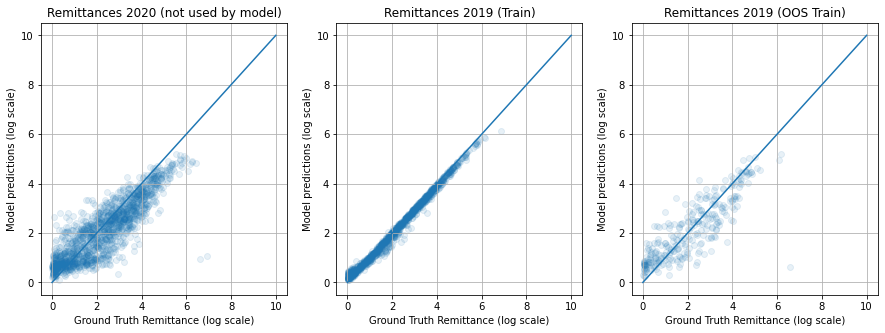

In [66]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
eval_set_name = ['Remittances 2020 (not used by model)', 'Remittances 2019 (Train)', 'Remittances 2019 (OOS Train)']
for it, (X, y_true) in enumerate(eval_set):
    y_pred = model.predict(X)
    
    ax[it].scatter(
        y_true.values,
        y_pred,
        alpha=.1)
    ax[it].set_title('%s' % eval_set_name[it])
    
    ax[it].plot([0, 10], [0, 10])
    ax[it].set_xlabel('Ground Truth Remittance (log scale)')
    ax[it].set_ylabel('Model predictions (log scale)')
    
    ax[it].grid()

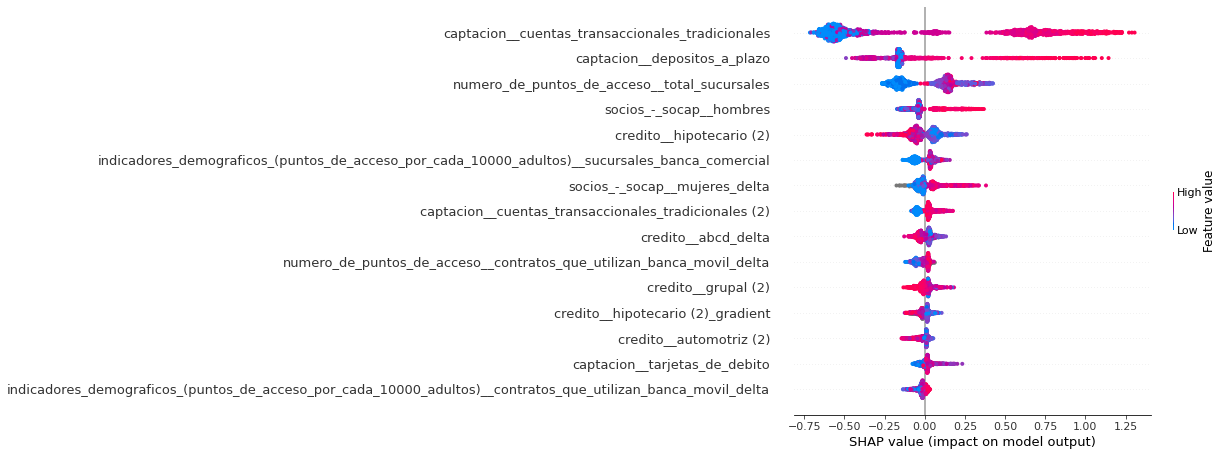

In [67]:
explainer = shap.TreeExplainer(model)

shap_values = explainer(
    X_2020)

features_shap_values = pd.DataFrame(
    shap_values.values,
    columns=X_2020.columns)

shap.summary_plot(
    shap_values, 
    X_2020, 
    max_display=15)

In [68]:
feature_list = features_shap_values.abs().sum().sort_values().index[-15:]

invalid value encountered in subtract


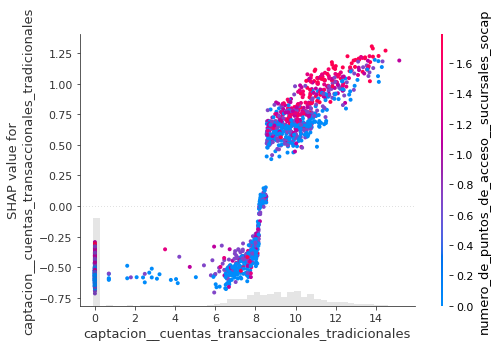

invalid value encountered in subtract


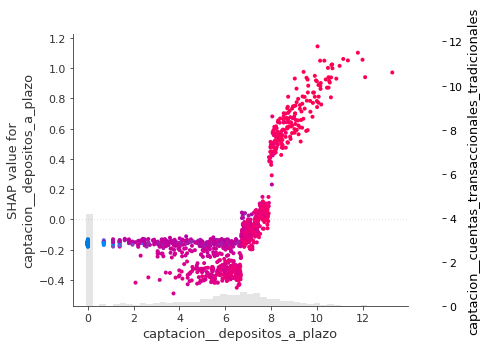

invalid value encountered in subtract


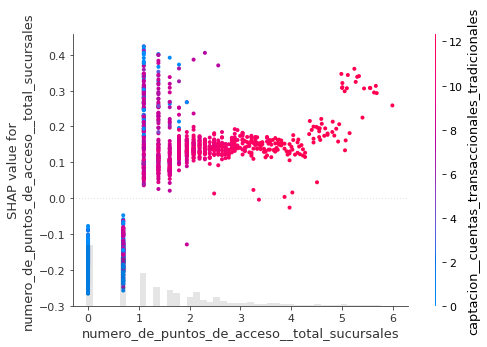

invalid value encountered in subtract


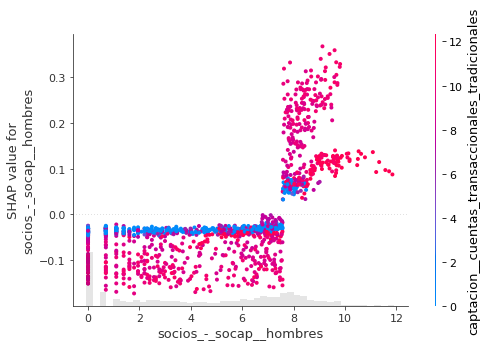

invalid value encountered in subtract


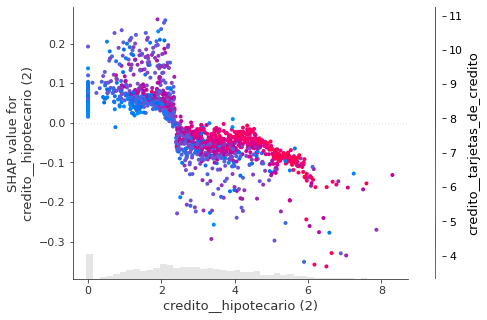

invalid value encountered in subtract


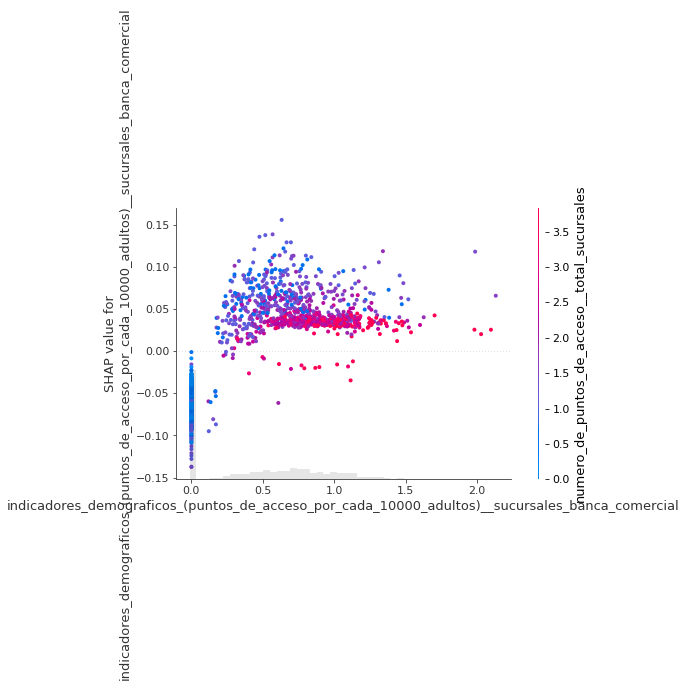

invalid value encountered in subtract


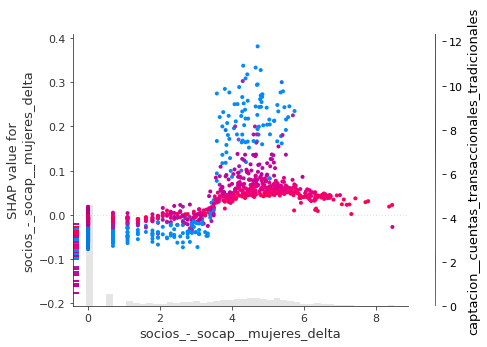

invalid value encountered in subtract


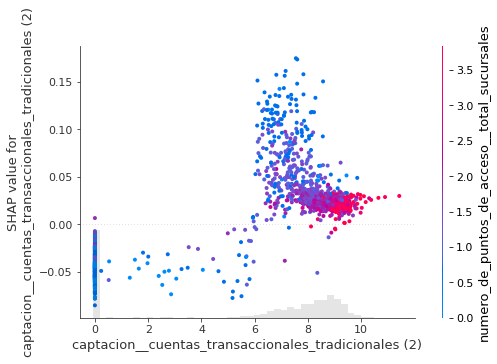

invalid value encountered in subtract


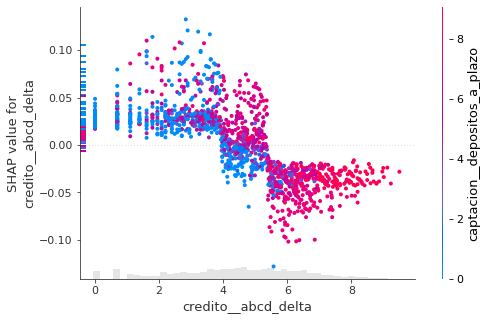

invalid value encountered in subtract


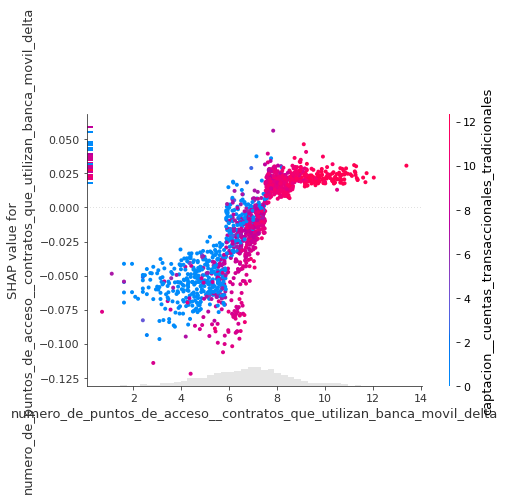

invalid value encountered in subtract


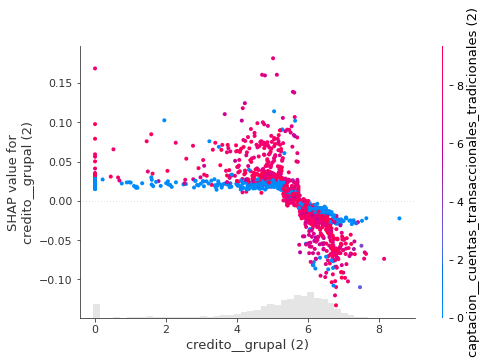

invalid value encountered in subtract


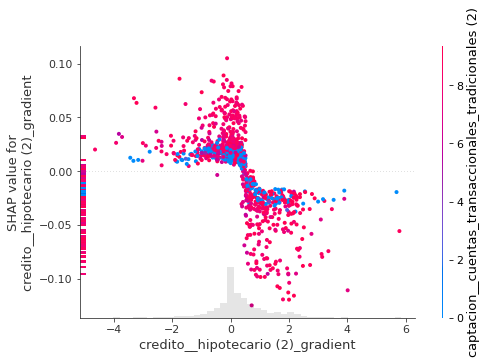

invalid value encountered in subtract


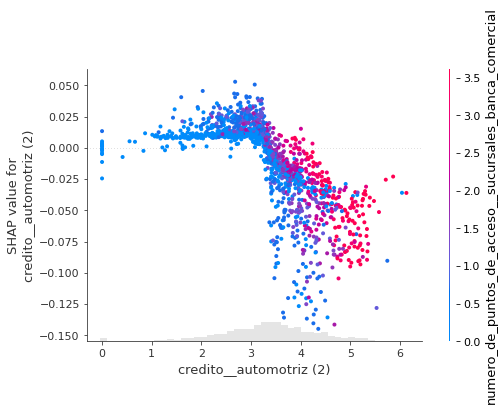

invalid value encountered in subtract


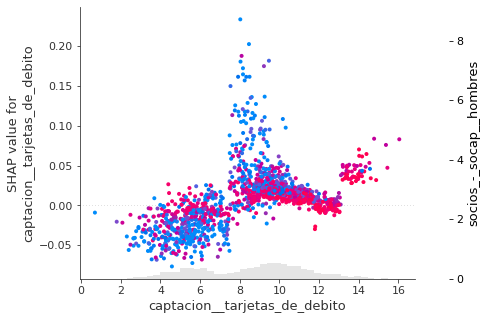

invalid value encountered in subtract


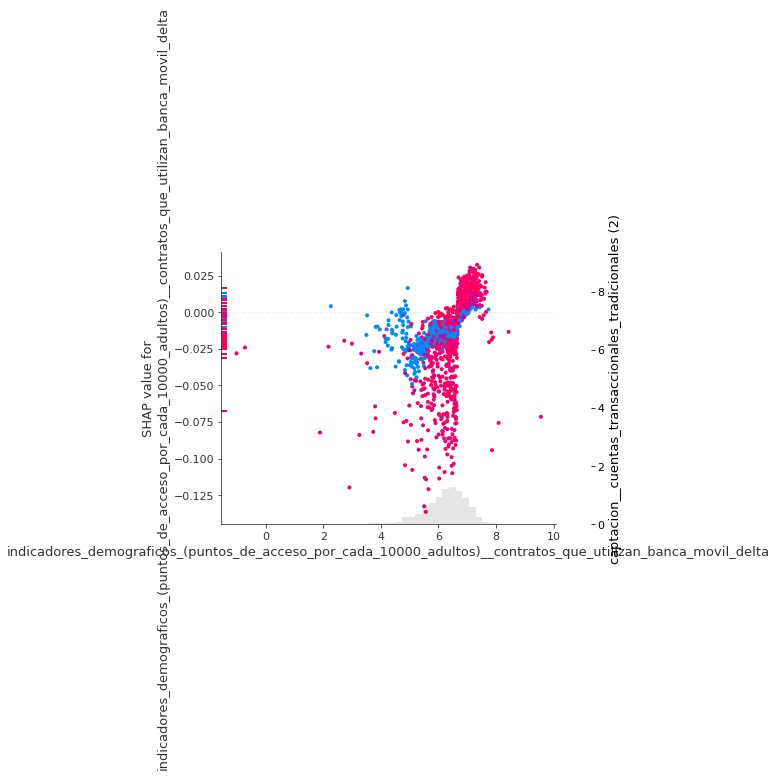

In [69]:
for f in reversed(feature_list):
    shap.plots.scatter(
        shap_values[:, f],
        color=shap_values)

[0]	validation_0-rmse:2.28864	validation_1-rmse:2.19701	validation_2-rmse:2.19739


savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6


[0]	validation_0-rmse:2.28864	validation_1-rmse:2.19701	validation_2-rmse:2.19739
[1]	validation_0-rmse:2.26945	validation_1-rmse:2.17698	validation_2-rmse:2.17882
[2]	validation_0-rmse:2.25013	validation_1-rmse:2.15717	validation_2-rmse:2.16029
[3]	validation_0-rmse:2.23136	validation_1-rmse:2.13758	validation_2-rmse:2.14217
[4]	validation_0-rmse:2.21282	validation_1-rmse:2.11817	validation_2-rmse:2.12407
[5]	validation_0-rmse:2.19425	validation_1-rmse:2.09898	validation_2-rmse:2.10636
[6]	validation_0-rmse:2.17614	validation_1-rmse:2.07999	validation_2-rmse:2.08865
[7]	validation_0-rmse:2.15772	validation_1-rmse:2.06116	validation_2-rmse:2.07127
[8]	validation_0-rmse:2.13973	validation_1-rmse:2.04252	validation_2-rmse:2.05405
[9]	validation_0-rmse:2.12172	validation_1-rmse:2.02407	validation_2-rmse:2.03699
[10]	validation_0-rmse:2.10436	validation_1-rmse:2.00585	validation_2-rmse:2.02017
[11]	validation_0-rmse:2.08682	validation_1-rmse:1.98777	validation_2-rmse:2.00350
[12]	validatio

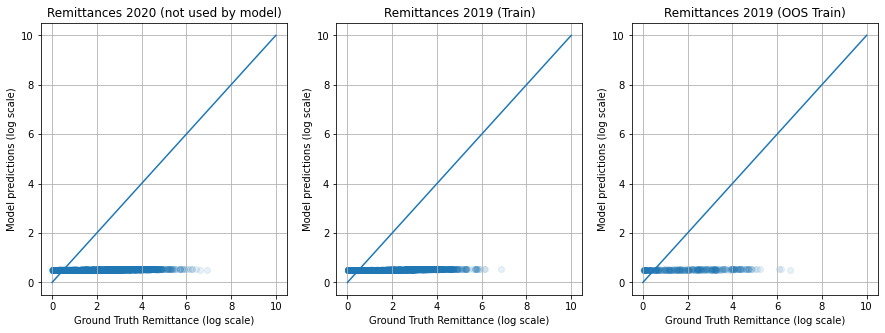

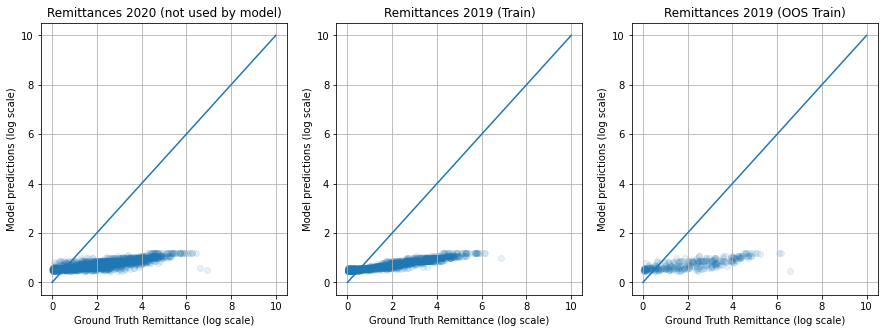

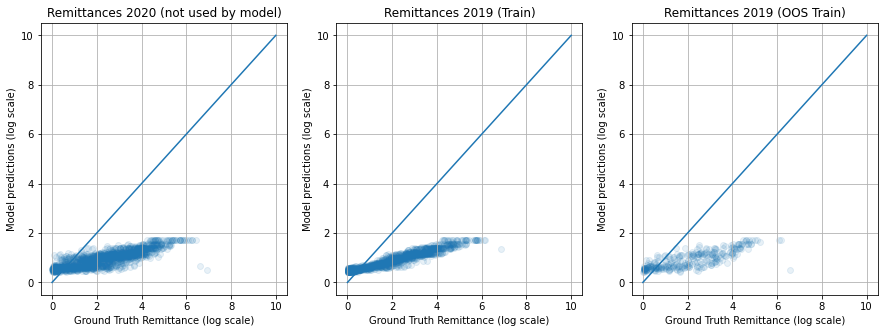

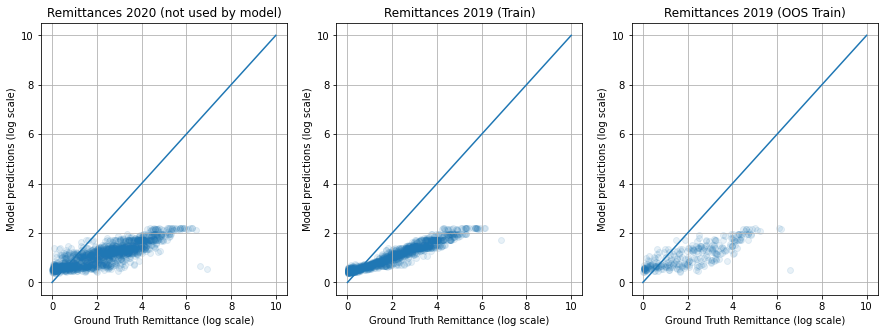

In [64]:
image_frame = []
for est in list(range(1,50,15)):

    X_train, X_test, y_train, y_test = train_test_split(
        X_2019, y_2019, 
        train_size=.8,
        random_state=1)

    eval_set = [
        (X_2020, y_2020),
        (X_train, y_train),
        (X_test, y_test)]

    model = XGBRegressor(
        learning_rate=0.01, 
        max_depth=8, 
        n_estimators=est)

    model.fit(
        X_train, y_train,
        eval_set=eval_set,
        early_stopping_rounds=10,
        verbose=True)
    
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    eval_set_name = ['Remittances 2020 (not used by model)', 'Remittances 2019 (Train)', 'Remittances 2019 (OOS Train)']
    for it, (X, y_true) in enumerate(eval_set):
        y_pred = model.predict(X)
    
        ax[it].scatter(
            y_true.values,
            y_pred,
            alpha=.1)
        ax[it].set_title('%s' % eval_set_name[it])
    
        ax[it].plot([0, 10], [0, 10])
        ax[it].set_xlabel('Ground Truth Remittance (log scale)')
        ax[it].set_ylabel('Model predictions (log scale)')
    
        ax[it].grid()

    
    img = ax[0].get_figure()
    f = io.BytesIO()
    img.savefig(f, format='png', bbox_inches='tight', quality=100)
    f.seek(0)
    image_frame.append(PIL.Image.open(f))
    image_frame[0].save('shap.gif', format='GIF', append_images=image_frame[1:],
                            save_all=True, duration=80, loop=10, quality=95, vmax=1)
    
    f.close()
    
    